In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999;

<IPython.core.display.Javascript object>

In [3]:
sys.path.insert(0, os.path.abspath('../'))
print(os.path.abspath('../'))
from uncertainty_estimation.experiments_utils.ood_experiments_utils import EICU_OOD_MAPPINGS

/home/dennis/uncertainty_estimation


In [4]:
EICU_PATH = "/data/processed/eicu_processed/data/adult_data.csv"
TARGET = "hospitaldischargestatus"

In [5]:
with open("./eICU_feature_names.pkl", "rb") as f:
    feat_columns = pickle.load(f)

In [6]:
eicu_data = pd.read_csv(EICU_PATH, dtype=float)
eicu_features = eicu_data[feat_columns + [TARGET]]
eicu_features[pd.isna(eicu_features)] = 0
X, y = eicu_features[feat_columns], eicu_features[TARGET]

/home/dennis/.conda/envs/eicu/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dennis/.conda/envs/eicu/lib/python3.7/site-packages/pandas/core/frame.py:3510: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [7]:
X_projected = np.load("eicu_projected.npy")

In [8]:
plt.rcParams["figure.figsize"] = (14,8)

def plot_group(group_name, X, y):

    for cls, label, color, alph in zip([0, 1], ["Rest", "Targets"], ["royalblue", "darkorange"], [0.3, 1]):
        plt.scatter(
            X_projected[:, 0][y == cls], X_projected[:, 1][y == cls], 
            alpha=alph, c=color, label=label, edgecolor="w"
        )
    plt.title(f"eICU stays '{group_name}' ({y.mean()*100:.2f} %)", fontsize=18)
    plt.legend(fontsize=14)
    plt.savefig(f"./eicu_{group_name.lower().replace('/', '_')}.png")
    plt.show()

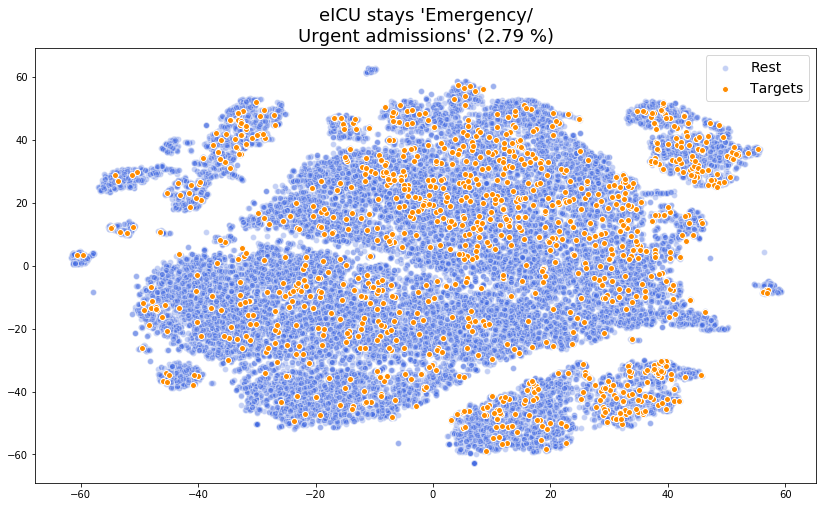

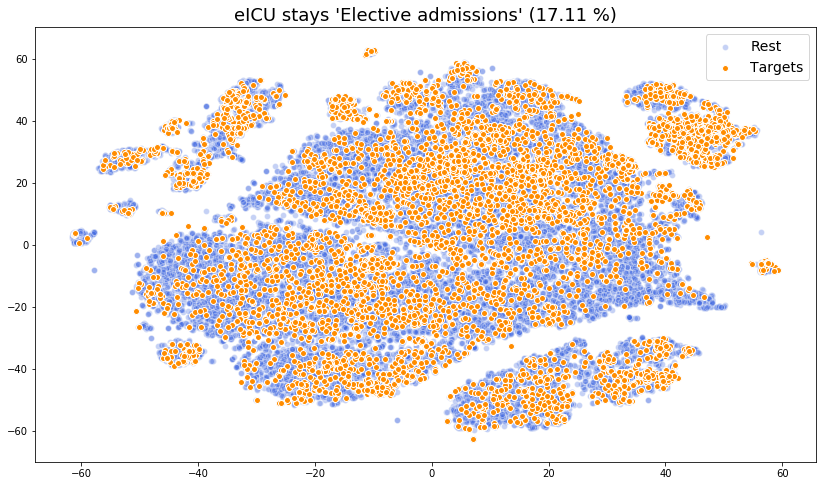

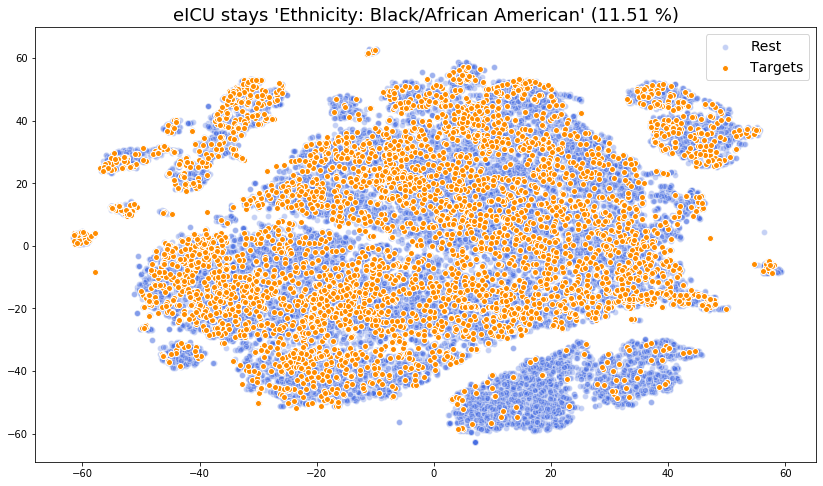

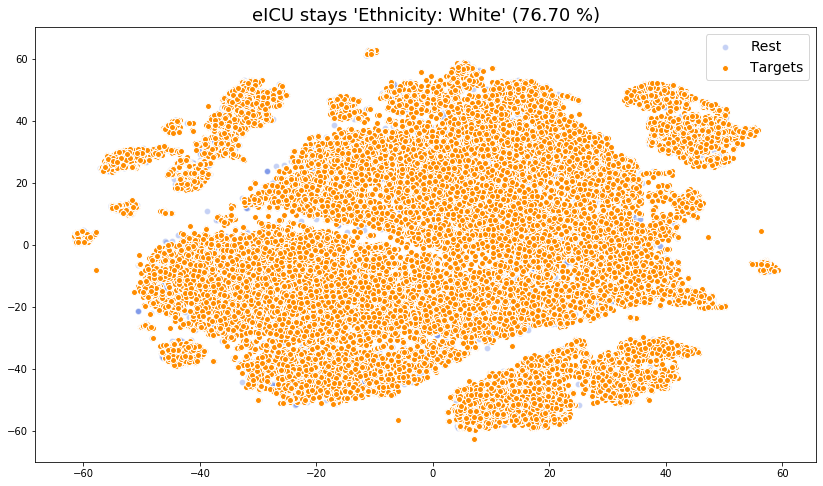

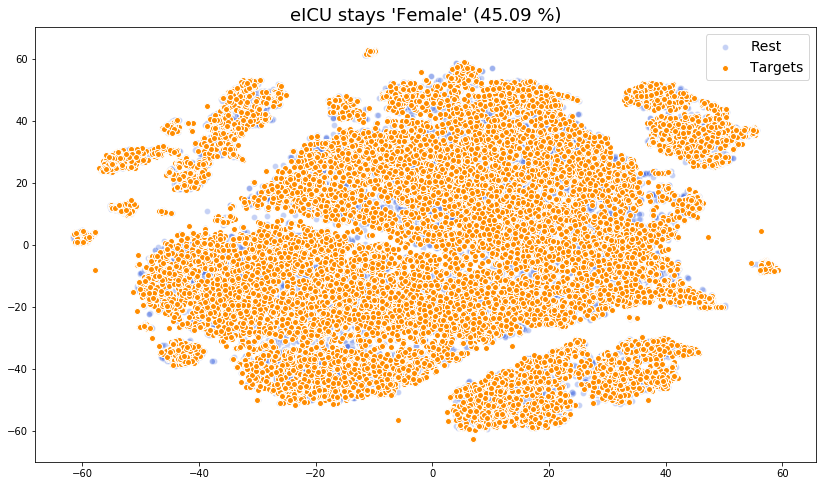

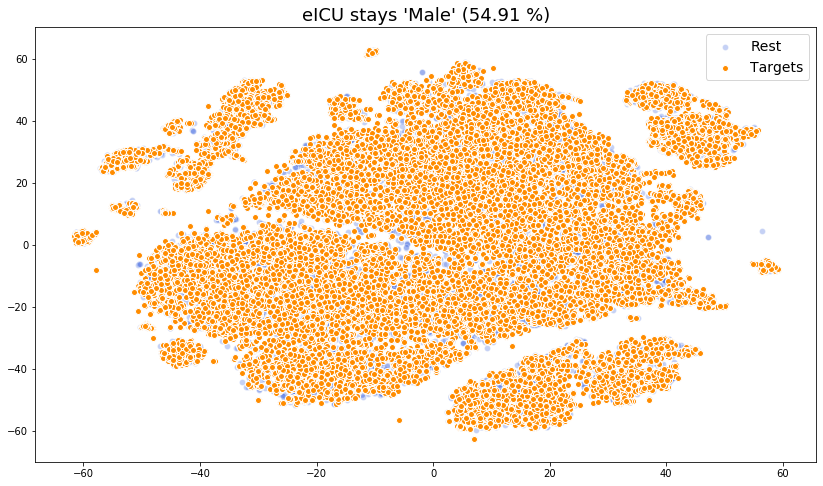

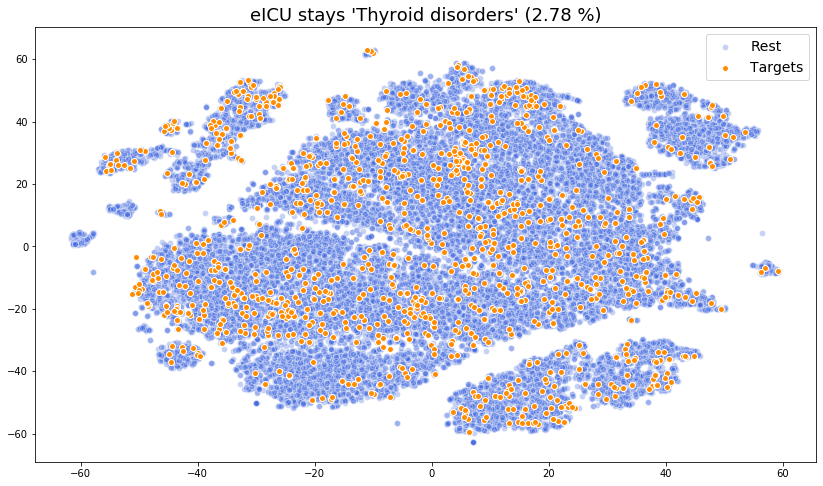

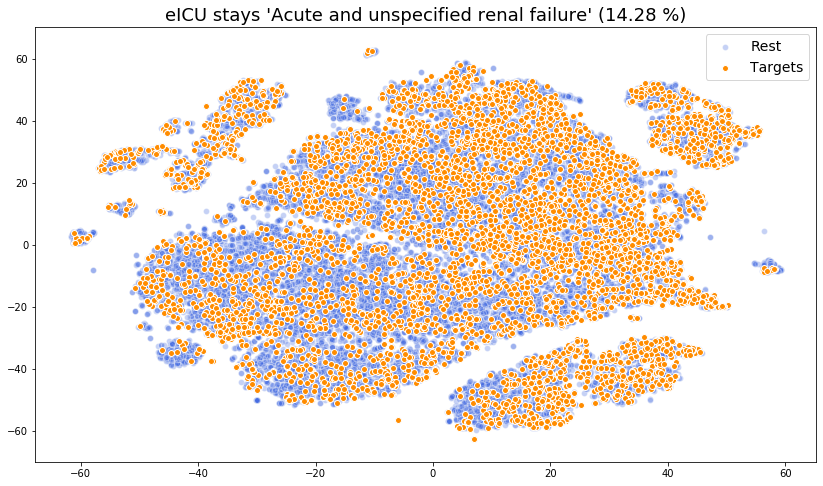

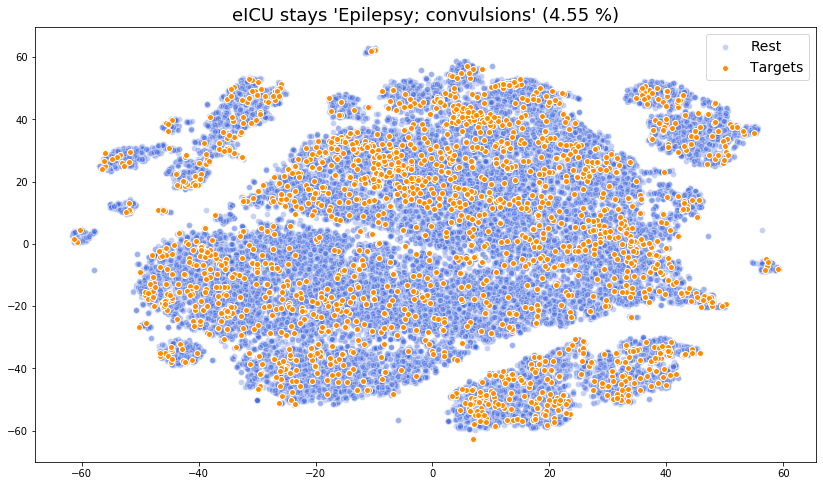

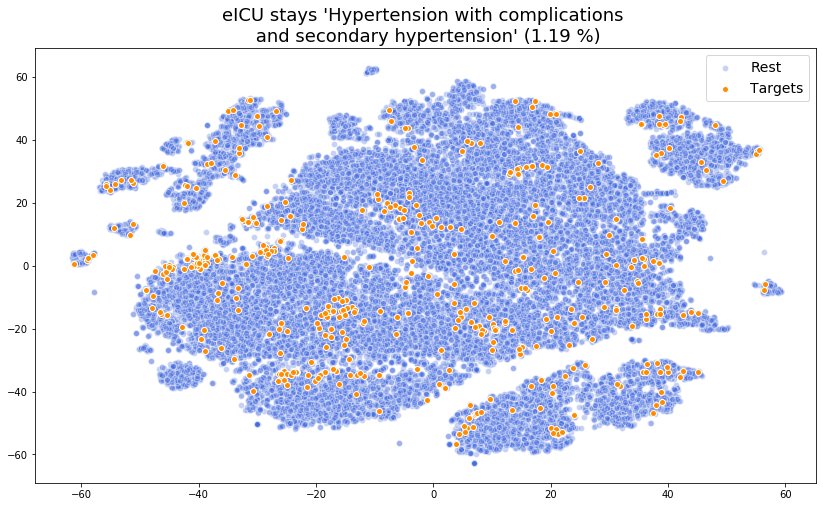

In [9]:
for group_name, filter_value in EICU_OOD_MAPPINGS.items():
    col, val = filter_value
    y_group = (eicu_data[col] == val).to_numpy()
    plot_group(group_name, X_projected, y_group)

In [10]:
# Plot by hospital 
PAT_EICU_PATH = "/data/processed/eicu_processed/unzipped/patient.csv"

In [14]:
patient_data = pd.read_csv(PAT_EICU_PATH)
patient_data = patient_data.set_index("patientunitstayid")

In [16]:
eicu_data["hospital_id"] = patient_data.lookup(eicu_data["patientunitstayid"], ["hospitalid"] * len(eicu_data))

In [72]:
hospitals = eicu_data["hospital_id"]
num_hospitals = len(eicu_data["hospital_id"].unique())
print(num_hospitals)
stay_freqs = np.bincount(eicu_data["hospital_id"])
stay_thresh = 500
stay_freqs[stay_freqs < stay_thresh] = 0

203


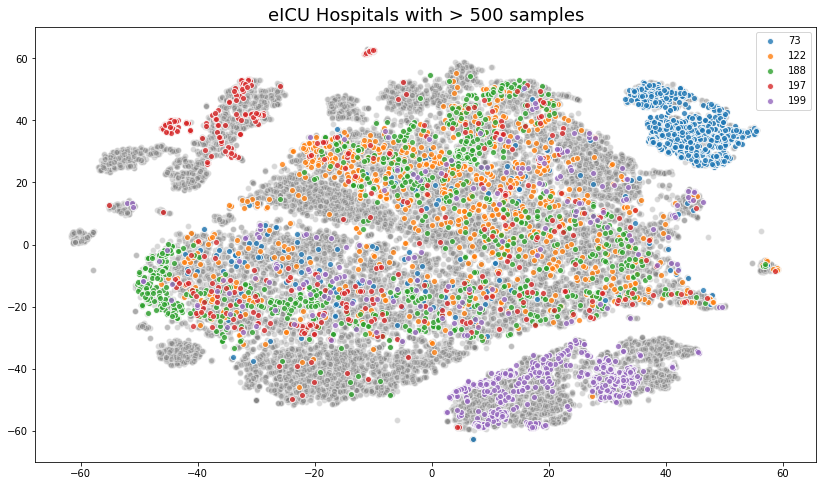

In [71]:
# Plot hospitals
plt.scatter(
    X_projected[:, 0][stay_freqs[hospitals] == 0], X_projected[:, 1][stay_freqs[hospitals] == 0], 
    alpha=0.3, color="gray", edgecolor="w"
) 

for hospital_id in range(num_hospitals):
    if stay_freqs[hospital_id] == 0:
        continue

    plt.scatter(
        X_projected[:, 0][hospitals == hospital_id], X_projected[:, 1][hospitals == hospital_id], 
        alpha=0.8, label=hospital_id, edgecolor="w"
    )
    
plt.title(f"eICU Hospitals with > {stay_thresh} samples", fontsize=18)
plt.savefig(f"./eicu_hospitals.png")
plt.legend()
plt.show()